<a href="https://colab.research.google.com/github/BMateusSs/Projeto-PISI3/blob/main/unsupervised_model_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
# Install dependencies as needed:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "winemag-data-130k-v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zynicide/wine-reviews",
  file_path
)

/tmp/ipython-input-85-1525670069.py:9: DeprecationWarning:

load_dataset is deprecated and will be removed in a future version.



Limpeza dos dados

In [86]:
initial_lines_quantity = len(df['description'])
print(initial_lines_quantity)
df.head()

129971


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [87]:
# Retirar linhas incompletas
df.dropna(axis="index", how= "any", subset=["price", "points", "region_1", "country", "variety", "designation"], inplace=True)
final_lines_quantity = len(df["description"])
print(final_lines_quantity)

70175


In [88]:
# Se for feito a limpeza das descrições para tirar stop words e pontuação
# sentence transformer já lida com o stop words e pontuação
import nltk
from nltk.corpus import stopwords
import string

# Baixe as stopwords se ainda não as tiver
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Converter para lowercase
    text = text.lower()
    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remover stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar a função de limpeza na coluna 'description'
df['description'] = df['description'].apply(clean_text)
df.head()
# geimport os

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
3,3,US,pineapple rind lemon pith orange blossom start...,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,much like regular bottling 2012 comes across r...,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,blackberry raspberry aromas show typical navar...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,heres bright informal red opens aromas candied...,Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,9,France,great depth flavor fresh apple pear fruits tou...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [56]:
# Gerar embdeings, só precisa fazer isso uma vez
# NÃO FAÇA ISSO NOVAMENTE SE JÁ POSSUI OS EMBEDINGS
from sentence_transformers import SentenceTransformer

# Defina o número de threads para usar todas as CPUs
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

# Ajuste o batch_size para melhor performance (ex: 128)
embeddings = model.encode(
    df['description'].tolist(),
    show_progress_bar=True,
    batch_size=128,
    device='cpu'  # Garante uso da CPU
)

KeyboardInterrupt: 

In [89]:
# Funções de escrita e leitura de arquivos numpy
import numpy as np
def write_numpy_file(write_path, content):
    np.save(write_path, content)

def read_numpy_file(read_path):
    return np.load(read_path)

# Funções de escrita e leitura de arquivos CSV
import numpy as np
import pandas as pd

def write_embeddings_csv(write_path: str, embeddings_array: np.ndarray):
    """Salva um array numpy de embeddings em um arquivo CSV."""
    # Converter o array numpy para um DataFrame pandas para facilitar o salvamento em CSV
    df_embeddings = pd.DataFrame(embeddings_array)
    # Salvar o DataFrame em CSV. index=False para não salvar o índice do DataFrame como coluna.
    df_embeddings.to_csv(write_path, index=False)
    print(f"Embeddings salvos como CSV em: {write_path}")


def read_embeddings_csv(read_path: str) -> np.ndarray:
    """Lê embeddings de um arquivo CSV e retorna como um array numpy."""
    # Ler o arquivo CSV para um DataFrame pandas
    df_embeddings = pd.read_csv(read_path)
    # Converter o DataFrame de volta para um array numpy
    embeddings_array = df_embeddings.values
    print(f"Embeddings lidos de CSV: {read_path}")
    return embeddings_array


In [ ]:
# Escrever no disco os embeddings
write_numpy_file(write_path=embeddings_path, content=embeddings)

NameError: name 'embeddings_path' is not defined

In [ ]:
# Ler os embeddings que estão salvo no disco
embeddings_path = "embeddings_paraphrase_multilingual_mpnet_base_v2.npy"
embeddings = read_numpy_file(embeddings_path)
len(embeddings)

FileNotFoundError: [Errno 2] No such file or directory: 'embeddings_paraphrase_multilingual_mpnet_base_v2.npy'

In [90]:
# funções para reduzir a dimensionalidade
def umap_fit_transform(embeddings, **kwargs):
    import umap
    reducer = umap.UMAP(**kwargs)
    umap_2d = reducer.fit_transform(embeddings)
    return umap_2d
def tsne_fit_transform(embeddings, **kwargs):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_2d = tsne.fit_transform(embeddings)
    return tsne_2d


In [ ]:
# Choose umap for generating 2d embedings
embeddings_2d = umap_fit_transform(embeddings, random_state=42)
len(embeddings_2d)


NameError: name 'embeddings' is not defined

In [ ]:
write_numpy_file("emdebddings_2d.npy", embeddings_2d)

NameError: name 'embeddings_2d' is not defined

In [91]:
#Ler emdebddings 2d
# Funções de escrita e leitura de arquivos CSV (mantenha essas funções definidas)
import numpy as np
import pandas as pd
import gdown
import os

# Mantenha a definição da função read_embeddings_csv
def read_embeddings_csv(read_path: str) -> np.ndarray:
    """Lê embeddings de um arquivo CSV e retorna como um array numpy."""
    # Ler o arquivo CSV para um DataFrame pandas
    df_embeddings = pd.read_csv(read_path)
    # Converter o DataFrame de volta para um array numpy
    embeddings_array = df_embeddings.values
    print(f"Embeddings lidos de CSV: {read_path}")
    return embeddings_array

# --- Agora, use o link do Google Drive para baixar e carregar ---

# Define o link do Google Drive para o arquivo CSV
# Gdown geralmente consegue lidar com o link 'sharing', mas o formato 'uc' é mais robusto para download direto.
# Vamos extrair o ID do link e usar o formato 'uc'.
drive_link = "https://drive.google.com/file/d/11-6rZ7TXr5Gato7iIkBHv8XYy5ScNqMx/view?usp=sharing"

# Extrair o ID do arquivo do link
# O ID está entre '/d/' e '/view'
drive_file_id = drive_link.split('/d/')[1].split('/view')[0]

# Construir o URL de download direto usando o ID
download_url = f"https://drive.google.com/uc?id={drive_file_id}"

# Define o caminho de saída onde o arquivo será salvo temporariamente no Colab
output_csv_path = "downloaded_embeddings_2d.csv"

print(f"Tentando baixar o arquivo do Google Drive ID: {drive_file_id}")

try:
    # Baixar o arquivo CSV usando gdown
    gdown.download(download_url, output_csv_path, quiet=False)
    print(f"Arquivo baixado com sucesso para {output_csv_path}")

    # Carregar o arquivo CSV baixado usando a função definida
    embeddings_2d = read_embeddings_csv(output_csv_path)

    print(f"Dados carregados na variável embeddings_2d. Forma: {embeddings_2d.shape}")

    # Opcional: remover o arquivo CSV baixado para liberar espaço
    # os.remove(output_csv_path)
    # print(f"Arquivo temporário {output_csv_path} removido.")

except Exception as e:
    print(f"Ocorreu um erro durante o download ou carregamento do CSV: {e}")
    print("Por favor, verifique se o link do Google Drive está correto e o arquivo é acessível (compartilhado).")

print(len(embeddings_2d))
# Agora a variável 'embeddings_2d' deve conter os dados carregados do CSV.
# Você pode continuar com as etapas de K-Means, etc., usando 'embeddings_2d'.

Tentando baixar o arquivo do Google Drive ID: 11-6rZ7TXr5Gato7iIkBHv8XYy5ScNqMx


Downloading...
From: https://drive.google.com/uc?id=11-6rZ7TXr5Gato7iIkBHv8XYy5ScNqMx
To: /content/downloaded_embeddings_2d.csv
100%|██████████| 1.43M/1.43M [00:00<00:00, 51.1MB/s]

Arquivo baixado com sucesso para downloaded_embeddings_2d.csv
Embeddings lidos de CSV: downloaded_embeddings_2d.csv
Dados carregados na variável embeddings_2d. Forma: (70175, 2)
70175


# Usando o k-means para gerar os clusters

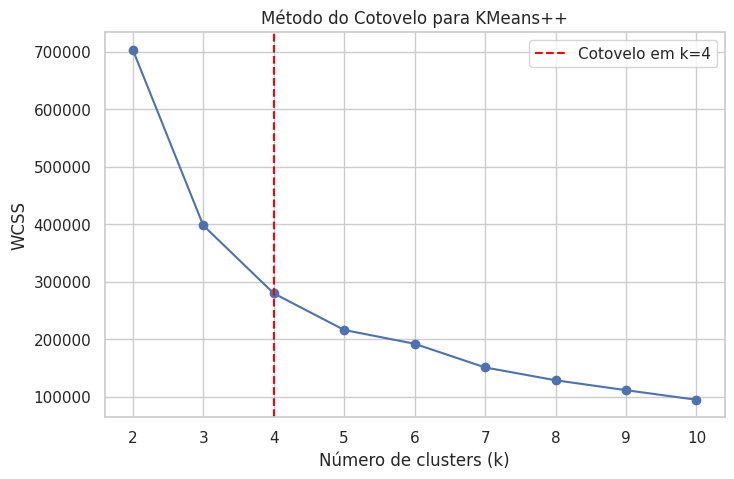

In [92]:
!pip install kneed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

wcss = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(embeddings_2d)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('WCSS')
plt.title('Método do Cotovelo para KMeans++')
plt.grid(True)

# Adicionar a linha tracejada vertical
# Substitua 'x_value' pelo valor de k onde você quer a linha vertical
kl=KneeLocator(K, wcss, curve="convex", direction="decreasing")
x_value = kl.elbow # Exemplo: adicione a linha tracejada em k = 4
plt.axvline(x=x_value, color='red', linestyle='--', label=f'Cotovelo em k={x_value}')

plt.legend() # Adicionar legenda para mostrar o rótulo da linha

plt.show()

In [93]:
# Após escolher o melhor k (exemplo: k=5)
best_k = kl.elbow
kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(embeddings_2d)
df['cluster'] = clusters


In [94]:
import numpy as np
from scipy.stats import zscore
import plotly.express as px
import pandas as pd

# Define o limite Z-score para remoção de outliers
# Um valor maior significa que menos outliers são removidos.
zscore_threshold = 3

# Certifica-se de que o DataFrame tem um índice contínuo após remoções anteriores
# Isso é crucial para alinhar com os embeddings 2D
df.reset_index(drop=True, inplace=True)

# Mantém o controle dos índices dos inliers (não outliers) no NOVO índice resetado
inlier_indices = []

# Itera por cada cluster para remover outliers dentro desse cluster
for cluster_id in sorted(df['cluster'].unique()):
    # Obtém os índices dos pontos de dados pertencentes ao cluster atual
    # Estes são os índices do DataFrame COM O ÍNDICE RESETADO
    cluster_indices = df[df['cluster'] == cluster_id].index

    # Obtém as coordenadas de embedding 2D para o cluster atual
    # Com o índice resetado, estes índices devem corresponder às posições em embeddings_2d
    cluster_umap_coords = embeddings_2d[cluster_indices]

    # Calcula o centroide (média) dos pontos no cluster atual
    centroid = np.mean(cluster_umap_coords, axis=0)

    # Calcula a distância de cada ponto do centroide
    distances = np.linalg.norm(cluster_umap_coords - centroid, axis=1)

    # Calcula os Z-scores para essas distâncias
    z_scores = zscore(distances)

    # Identifica os índices dos pontos dentro do cluster atual que *não* são outliers
    # Estes inlier_indices serão baseados no índice resetado
    current_cluster_inlier_indices = cluster_indices[np.abs(z_scores) < zscore_threshold]

    # Adiciona esses índices de inliers à lista principal
    inlier_indices.extend(current_cluster_inlier_indices)

# Crie a máscara booleana para todos os inliers COM BASE NO ÍNDICE ATUAL DO DATAFRAME RESETADO
mask = np.zeros(len(df), dtype=bool)
mask[inlier_indices] = True

# Identifica os índices dos outliers
# Note que estamos trabalhando com o índice resetado do df aqui
all_indices = set(df.index)
inlier_indices_set = set(inlier_indices)
outlier_indices = list(all_indices - inlier_indices_set)

# Remove os outliers identificados do DataFrame
# O drop usará os índices do DataFrame resetado
df.drop(outlier_indices, inplace=True)

# Atualiza o array embeddings_2d para conter apenas os pontos que não são outliers
# Use a máscara baseada nos índices resetados
embeddings_2d = embeddings_2d[mask]


# Imprime o número de pontos de dados restantes para verificar a remoção
print(f"Número de linhas no DataFrame após remoção de outliers: {len(df)}")
print(f"Número de linhas em embeddings_2d após remoção de outliers: {len(embeddings_2d)}")

Número de linhas no DataFrame após remoção de outliers: 69683
Número de linhas em embeddings_2d após remoção de outliers: 69683


In [95]:
# Antes do bloco de remoção de outliers:

# Resetar o índice do DataFrame para garantir que seja sequencial (0, 1, 2, ...)
# Isso é útil se linhas foram removidas anteriormente e o índice ficou "furado".
df.reset_index(drop=True, inplace=True)

# Agora, garanta que embeddings_2d corresponda a este DataFrame
# Se você acabou de gerar embeddings_2d antes deste bloco de remoção de outliers,
# ele já deve estar alinhado. Mas se embeddings_2d foi carregado ou manipulado
# de outra forma, pode ser necessário filtrá-lo para corresponder ao df atual.

# Se embeddings_2d foi gerado APÓS a limpeza inicial do df:
# embeddings_2d = umap_fit_transform(embeddings_DO_DF_FILTRADO, random_state=42) # Exemplo, dependendo de como você o gerou

# Se embeddings_2d foi carregado de um arquivo, você pode precisar
# filtrá-lo para corresponder aos índices do df atual:
# (Esta é uma solução mais complexa e depende de como embeddings_2d foi salvo com os índices originais)
# Por enquanto, vamos assumir que resetar o índice do df resolve.


# --- Bloco de remoção de outliers (com a correção anterior para mask e cluster_umap_coords) ---

# Remoção de outliers
import numpy as np
from scipy.stats import zscore

# Threshold for Z-score to consider a point an outlier
zscore_threshold = 3

# Initialize a list to store indices of inliers (non-outliers)
inlier_indices = []

# Iterate through each cluster
for cluster_id in sorted(df['cluster'].unique()):
    # Get indices of points belonging to the current cluster
    # Agora, cluster_indices virão do índice resetado (0, 1, 2, ...)
    cluster_indices = df[df['cluster'] == cluster_id].index

    # Get the UMAP coordinates for the current cluster
    # Com o índice resetado, estes índices devem corresponder às posições em embeddings_2d
    cluster_umap_coords = embeddings_2d[cluster_indices]

    # Calculate the centroid for the current cluster
    centroid = np.mean(cluster_umap_coords, axis=0)

    # Calculate the distance of each point in the cluster from the centroid
    distances = np.linalg.norm(cluster_umap_coords - centroid, axis=1)

    # Calculate Z-scores for the distances
    z_scores = zscore(distances)

    # Identify inlier indices within the current cluster
    # Estes inlier_indices serão baseados no índice resetado
    current_cluster_inlier_indices = cluster_indices[np.abs(z_scores) < zscore_threshold]

    # Add the inlier indices to the main list
    inlier_indices.extend(current_cluster_inlier_indices)

# Crie a máscara booleana para todos os inliers COM BASE NO ÍNDICE ATUAL DO DATAFRAME RESETADO
mask = np.zeros(len(df), dtype=bool)
mask[inlier_indices] = True

# Identifique os índices dos outliers
all_indices = set(df.index)
inlier_indices_set = set(inlier_indices)
outlier_indices = list(all_indices - inlier_indices_set)

# Remova os outliers do DataFrame
# O drop usará os índices do DataFrame resetado
df.drop(outlier_indices, inplace=True)

# Atualiza o array embeddings_2d para conter apenas os pontos que não são outliers
# Use a máscara baseada nos índices resetados
embeddings_2d = embeddings_2d[mask]

# Verifique se o número de linhas em df e embeddings_2d é o mesmo após a remoção
print(f"Número de linhas no DataFrame após remoção de outliers: {len(df)}")
print(f"Número de linhas em embeddings_2d após remoção de outliers: {len(embeddings_2d)}")

Número de linhas no DataFrame após remoção de outliers: 69494
Número de linhas em embeddings_2d após remoção de outliers: 69494


In [96]:
import plotly.express as px
import pandas as pd

print(len(embeddings_2d))
print(len(df['description']))

# Supondo que embeddings_2d e df já foram filtrados após a remoção de outliers
# e que o índice de df foi resetado.

# Use os dados FILTRADOS do DataFrame df para as colunas 'Cluster' e 'Região'
df_plot = pd.DataFrame({
    'UMAP1': embeddings_2d[:, 0],
    'UMAP2': embeddings_2d[:, 1],
    'Cluster': df['cluster'].values.astype(str),  # Use a coluna 'cluster' do DataFrame filtrado
    'Região': df['region_1'].values            # Use a coluna 'region_1' do DataFrame filtrado
})

fig = px.scatter(
    df_plot, x='UMAP1', y='UMAP2',
    color='Cluster',
    hover_data=['Região'],
    title='Clusters de Embeddings (UMAP + KMeans++)'
)
fig.show()

69494
69494


# Analisando dados dos Clusters

/tmp/ipython-input-12-680801797.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




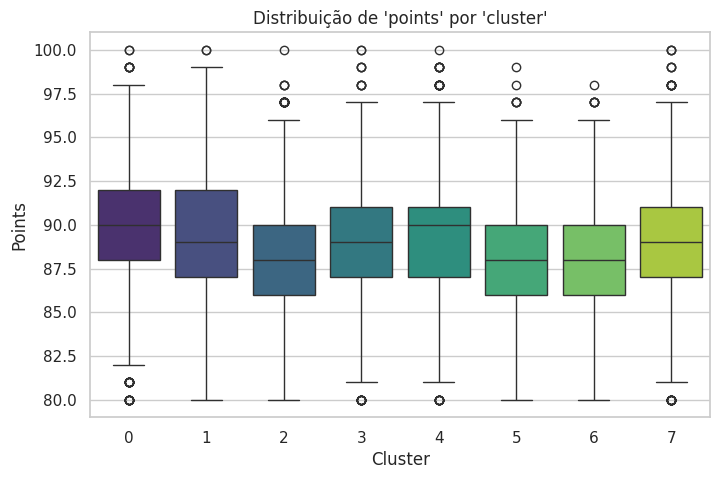

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.boxplot(x='cluster', y='points', data=df, palette="viridis")
plt.title("Distribuição de 'points' por 'cluster'")
plt.xlabel("Cluster")
plt.ylabel("Points")
plt.show()

/tmp/ipython-input-13-1637322125.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




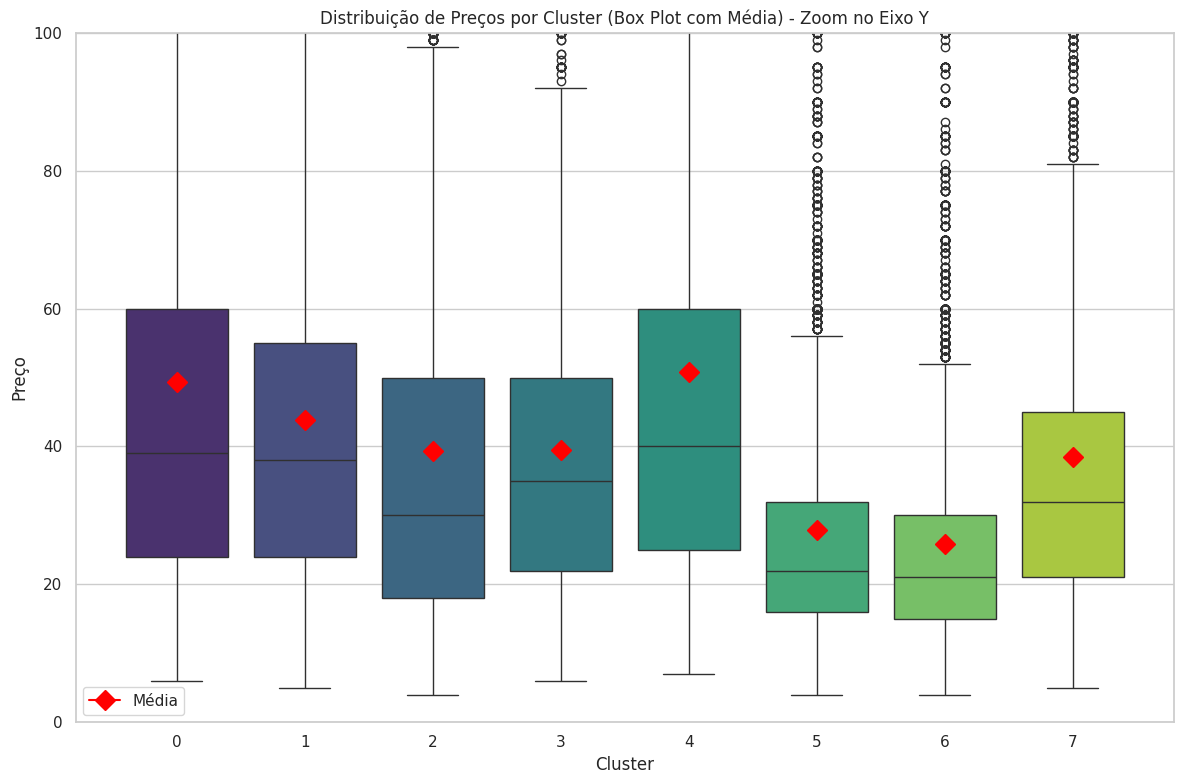


Média de Preço por Cluster:
cluster
0    49.420006
1    43.839322
2    39.332957
3    39.450000
4    50.847072
5    27.822238
6    25.838451
7    38.416507
Name: price, dtype: float64

Mediana de Preço por Cluster:
cluster
0    39.0
1    38.0
2    30.0
3    35.0
4    40.0
5    22.0
6    21.0
7    32.0
Name: price, dtype: float64

Desvio Padrão de Preço por Cluster:
cluster
0    46.516518
1    35.233927
2    34.695258
3    29.437985
4    42.419620
5    30.677210
6    17.091626
7    30.232682
Name: price, dtype: float64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configure o estilo do gráfico
sns.set_theme(style="whitegrid")

# Crie a figura e os eixos para o Box Plot
plt.figure(figsize=(12, 8)) # Ajuste o tamanho da figura conforme necessário

# Gere o Box Plot
boxplot_ax = sns.boxplot(x='cluster', y='price', data=df, palette="viridis")

# Calcule a média de preço por cluster
media_preco_por_cluster = df.groupby('cluster')['price'].mean().reset_index()
media_preco_por_cluster.columns = ['cluster', 'mean_price']

# Adicione marcadores para a média no Box Plot
for i, cluster_id in enumerate(sorted(df['cluster'].unique())):
    media = media_preco_por_cluster[media_preco_por_cluster['cluster'] == cluster_id]['mean_price'].iloc[0]
    boxplot_ax.plot(i, media, marker='D', color='red', markersize=10, label='Média' if i == 0 else "")

# --- ADICIONAR ZOOM AQUI ---
# Ajuste os limites do eixo Y para "dar zoom"
# Substitua y_min e y_max por valores apropriados para seus dados
y_min = 0  # Exemplo: limite inferior
y_max = 100 # Exemplo: limite superior. Ajuste este valor com base nos seus dados.
plt.ylim(y_min, y_max)
# --- FIM DO ZOOM ---


# Adicione título e rótulos aos eixos
plt.title("Distribuição de Preços por Cluster (Box Plot com Média) - Zoom no Eixo Y")
plt.xlabel("Cluster")
plt.ylabel("Preço")

# Rotacione os rótulos do eixo x se necessário para melhor legibilidade
plt.xticks(rotation=0)

# Adicione uma legenda para o marcador de média
plt.legend()

# Ajuste o layout para evitar sobreposição
plt.tight_layout()

# Exiba o gráfico
plt.show()

# Opcionalmente, para ver os valores exatos da média e desvio padrão:
print("\nMédia de Preço por Cluster:")
print(df.groupby('cluster')['price'].mean())

print("\nMediana de Preço por Cluster:")
print(df.groupby('cluster')['price'].median())

print("\nDesvio Padrão de Preço por Cluster:")
print(df.groupby('cluster')['price'].std())

In [14]:
def cross_columns_with_cluster(column: str):
        # Tem diversidade de países em cada cluster
    clusters_por_pais = df.groupby(column)['cluster'].nunique().sort_values(ascending=False)
    print(clusters_por_pais)

    # Para visualizar a distribuição detalhada:
    distribuicao = pd.crosstab(df[column], df['cluster'])
    print(distribuicao)

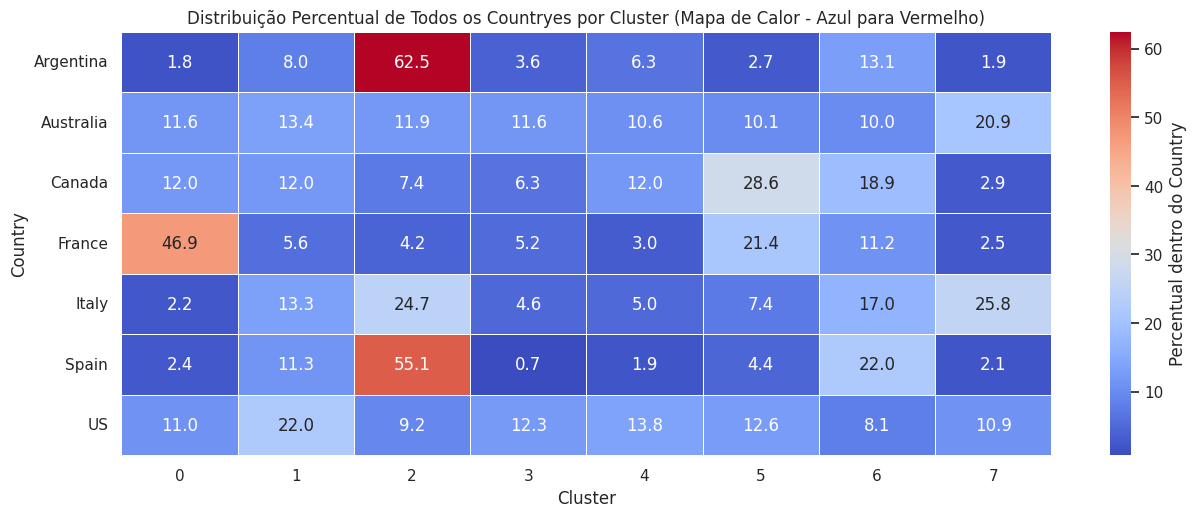

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np # Importar numpy para normalização

def plot_top_n_heatmap_per_cluster_normalized_by_row(col: str, n: int = 10):
    """
    Gera um mapa de calor mostrando a distribuição percentual das top N entradas
    de uma coluna categórica através dos clusters, normalizado por linha.

    Args:
        col (str): O nome da coluna no DataFrame para analisar (ex: 'designation', 'variety').
        n (int): O número de top entradas a serem incluídas no heatmap.
    """
    # Seleciona as N entradas mais populares da coluna
    # Se n for None, seleciona todas as entradas únicas
    if n is not None:
        top_entries = df[col].value_counts().nlargest(n).index
        title_prefix = f'Top {n} {col.capitalize()}'
        figsize_height = n * 0.5 + 2
        df_top = df[df[col].isin(top_entries)]
    else:
        top_entries = df[col].unique()
        title_prefix = f'Todos os {col.capitalize()}es'
        figsize_height = len(top_entries) * 0.5 + 2
        df_top = df.copy() # Usa o DataFrame completo

    # Cria a tabela de contagem cruzada: linhas = top_entries, colunas = cluster, valores = contagem
    pivot_table = pd.crosstab(df_top[col], df_top['cluster'])

    # Garante que a ordem das linhas no heatmap corresponda à popularidade (se n não for None)
    if n is not None:
         pivot_table = pivot_table.loc[top_entries]

    # --- Normaliza a tabela por linha ---
    # Divide cada valor na linha pela soma dos valores na linha
    pivot_table_normalized = pivot_table.divide(pivot_table.sum(axis=1), axis=0) * 100 # Multiplica por 100 para ter percentual
    # Substitui NaN por 0 em caso de linhas com soma zero (embora improvável com contagens)
    pivot_table_normalized = pivot_table_normalized.fillna(0)
    # --- Fim da normalização ---

    # Cria o mapa de calor a partir dos dados normalizados
    plt.figure(figsize=(15, figsize_height)) # Ajusta o tamanho da figura dinamicamente
    sns.heatmap(
        pivot_table_normalized, # Usa a tabela normalizada
        annot=True,  # Mostrar os números no heatmap (agora percentuais)
        fmt='.1f',   # Formatar os números como floats com 1 casa decimal
        cmap='coolwarm', # Altera a paleta de cores para Azul para Vermelho
        linewidths=.5, # Adiciona linhas entre as células para melhor visualização
        cbar_kws={'label': f'Percentual dentro do {col.capitalize()}'} # Rótulo da barra de cores
    )
    plt.title(f'Distribuição Percentual de {title_prefix} por Cluster (Mapa de Calor - Azul para Vermelho)')
    plt.xlabel('Cluster')
    plt.ylabel(col.capitalize())
    plt.show()

# Gerar o mapa de calor normalizado por linha para os países
# Escolha entre n=None (todos os países) ou um número (ex: n=10 para top 10)
plot_top_n_heatmap_per_cluster_normalized_by_row(col='country', n=None) # Exemplo: todos os países

# Ou para os top 10 países:
# plot_top_n_heatmap_per_cluster_normalized_by_row(col='country', n=10)

In [16]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_country_cluster_association(df, n_top_countries: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'country' (focando nos top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'country' e 'cluster'.
        n_top_countries (int): O número de top países a serem incluídos no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona os N países mais populares
    top_countries = df['country'].value_counts().nlargest(n_top_countries).index

    # Filtra o DataFrame para incluir apenas as linhas com esses top países
    df_filtered = df[df['country'].isin(top_countries)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['country'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_countries} Países e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre país (top N) e cluster.")
        print("Isso sugere que a distribuição dos países é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição dos países (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com os top 10 países
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_country_cluster_association(df, n_top_countries=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Países):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Países):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Países e Clusters:
Estatística Qui-Quadrado: 33347.1888
Valor p: 0.0000
Graus de Liberdade: 42

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre país (top N) e cluster.
Isso sugere que a distribuição dos países é significativamente diferente entre os clusters.


In [17]:
print(len(df['designation']))

69850


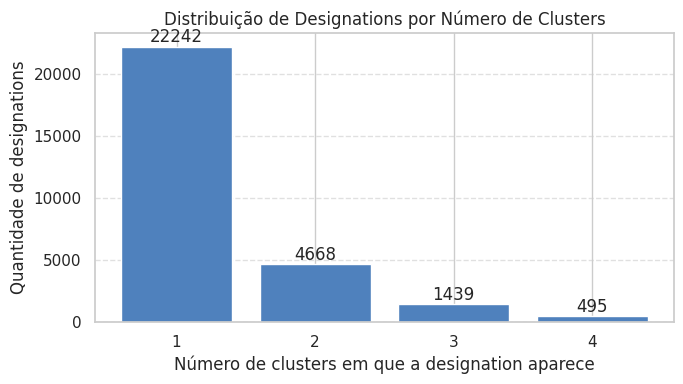

In [18]:
# Não existe diversidade nos clusteres de um mesmo tipo de vinho
import matplotlib.pyplot as plt
import pandas as pd

# Passo 1: Conta em quantos clusters cada designation aparece
clusters_por_designation = df.groupby('designation')['cluster'].nunique()

# Passo 2: Conta quantas designations aparecem em 1, 2, 3 ou 4 clusters
contagem = clusters_por_designation.value_counts().sort_index()
# Garante que todos os valores de 1 a 4 estejam presentes
contagem = contagem.reindex([1, 2, 3, 4], fill_value=0)

import matplotlib.pyplot as plt

# clusters_por_designation e contagem já definidos como no seu código

plt.figure(figsize=(7, 4))
bars = plt.bar(contagem.index, contagem.values, color='#4F81BD')
plt.xlabel('Número de clusters em que a designation aparece')
plt.ylabel('Quantidade de designations')
plt.title('Distribuição de Designations por Número de Clusters')
plt.xticks(contagem.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adiciona os valores acima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

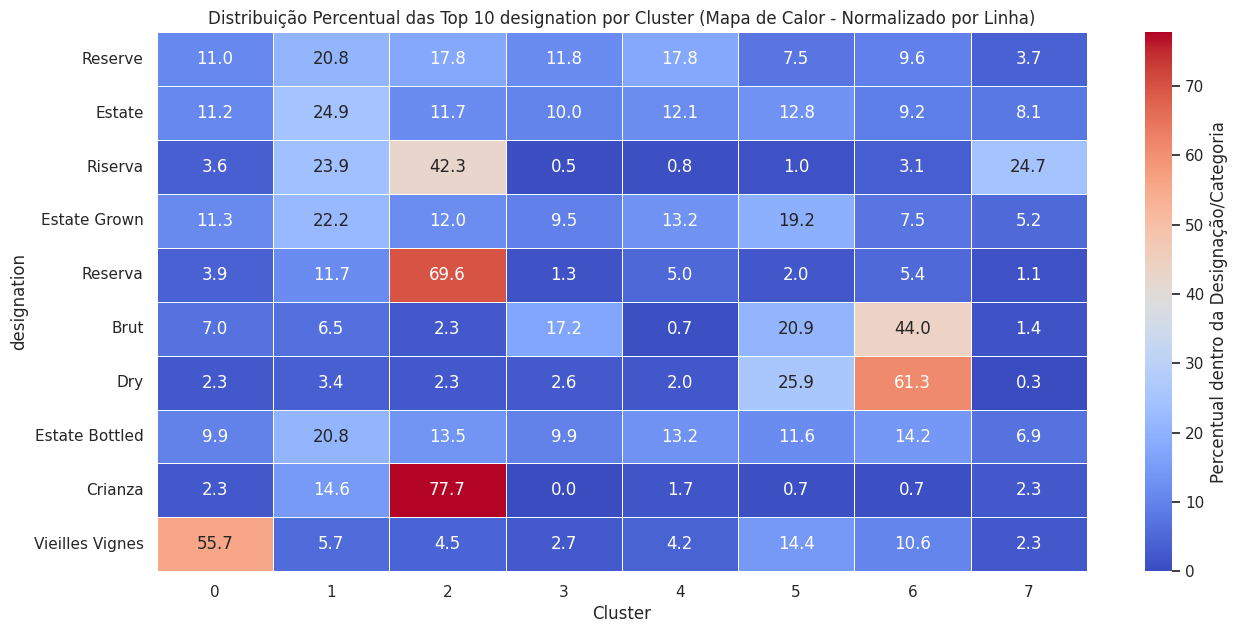

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np # Importar numpy para normalização

def plot_top_n_heatmap_per_cluster_normalized_by_row(col: str, n: int = 10):
    """
    Gera um mapa de calor mostrando a distribuição percentual das top N entradas
    de uma coluna categórica através dos clusters, normalizado por linha.

    Args:
        col (str): O nome da coluna no DataFrame para analisar (ex: 'designation', 'variety').
        n (int): O número de top entradas a serem incluídas no heatmap.
    """
    # Seleciona as N entradas mais populares da coluna
    top_entries = df[col].value_counts().nlargest(n).index

    # Filtra o DataFrame para incluir apenas as linhas com essas top entradas
    df_top = df[df[col].isin(top_entries)]

    # Cria a tabela de contagem cruzada: linhas = top_entries, colunas = cluster, valores = contagem
    pivot_table = pd.crosstab(df_top[col], df_top['cluster'])

    # Garante que a ordem das linhas no heatmap corresponda à popularidade
    pivot_table = pivot_table.loc[top_entries]

    # --- Normaliza a tabela por linha ---
    # Divide cada valor na linha pela soma dos valores na linha
    pivot_table_normalized = pivot_table.divide(pivot_table.sum(axis=1), axis=0) * 100 # Multiplica por 100 para ter percentual
    # Substitui NaN por 0 em caso de linhas com soma zero (embora improvável com contagens)
    pivot_table_normalized = pivot_table_normalized.fillna(0)
    # --- Fim da normalização ---

    # Cria o mapa de calor a partir dos dados normalizados
    plt.figure(figsize=(15, n * 0.5 + 2)) # Ajusta o tamanho da figura dinamicamente
    sns.heatmap(
        pivot_table_normalized, # Usa a tabela normalizada
        annot=True,  # Mostrar os números no heatmap (agora percentuais)
        fmt='.1f',   # Formatar os números como floats com 1 casa decimal
        cmap='coolwarm', # Azul para menos, Vermelho para mais
        linewidths=.5, # Adiciona linhas entre as células para melhor visualização
        cbar_kws={'label': 'Percentual dentro da Designação/Categoria'} # Rótulo da barra de cores
    )
    plt.title(f'Distribuição Percentual das Top {n} {col} por Cluster (Mapa de Calor - Normalizado por Linha)')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.show()

# Gerar o mapa de calor normalizado por linha para as top 10 designações
plot_top_n_heatmap_per_cluster_normalized_by_row(col='designation', n=10)

In [20]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_designation_cluster_association(df, n_top_designations: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'designation' (focando nas top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'designation' e 'cluster'.
        n_top_designations (int): O número de top designações a serem incluídas no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona as N designações mais populares
    top_designations = df['designation'].value_counts().nlargest(n_top_designations).index

    # Filtra o DataFrame para incluir apenas as linhas com essas top designações
    df_filtered = df[df['designation'].isin(top_designations)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['designation'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_designations} Designações e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre designação (top N) e cluster.")
        print("Isso sugere que a distribuição das designações é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição das designações (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com as top 10 designações
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_designation_cluster_association(df, n_top_designations=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Designações):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Designações):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Designações e Clusters:
Estatística Qui-Quadrado: 4290.0296
Valor p: 0.0000
Graus de Liberdade: 63

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre designação (top N) e cluster.
Isso sugere que a distribuição das designações é significativamente diferente entre os clusters.


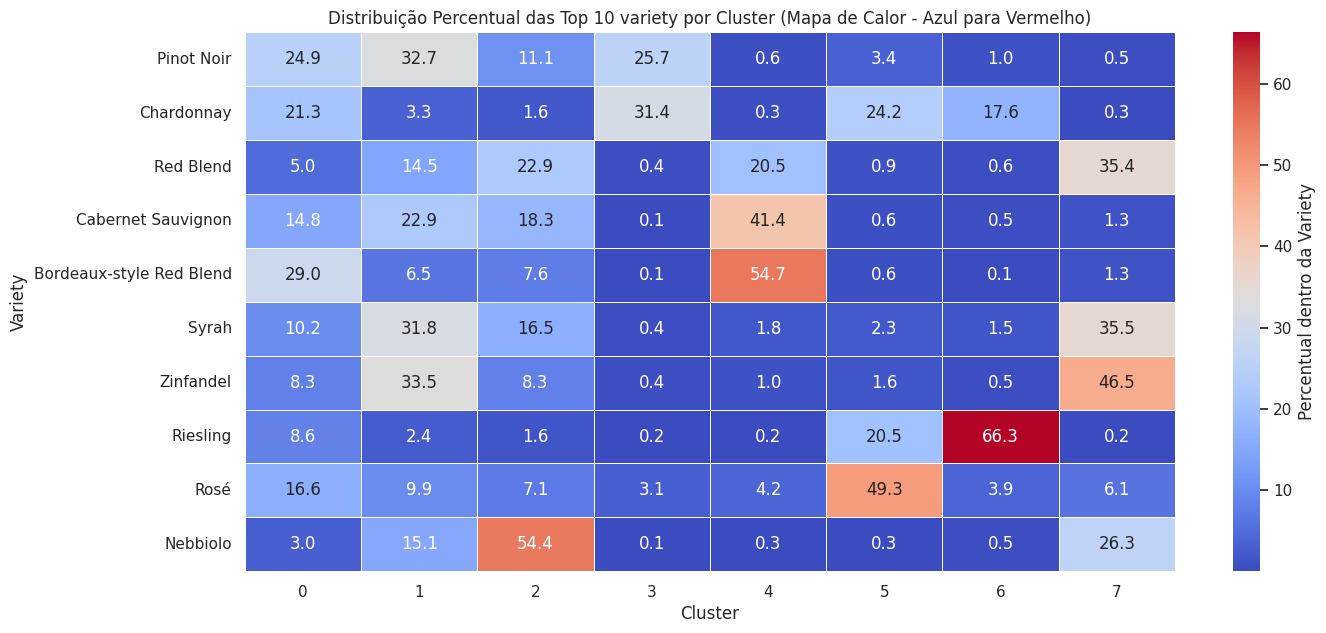

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np # Importar numpy para normalização

def plot_top_n_heatmap_per_cluster_normalized_by_row(col: str, n: int = 10):
    """
    Gera um mapa de calor mostrando a distribuição percentual das top N entradas
    de uma coluna categórica através dos clusters, normalizado por linha.

    Args:
        col (str): O nome da coluna no DataFrame para analisar (ex: 'designation', 'variety').
        n (int): O número de top entradas a serem incluídas no heatmap.
    """
    # Seleciona as N entradas mais populares da coluna
    top_entries = df[col].value_counts().nlargest(n).index

    # Filtra o DataFrame para incluir apenas as linhas com essas top entradas
    df_top = df[df[col].isin(top_entries)]

    # Cria a tabela de contagem cruzada: linhas = top_entries, colunas = cluster, valores = contagem
    pivot_table = pd.crosstab(df_top[col], df_top['cluster'])

    # Garante que a ordem das linhas no heatmap corresponda à popularidade
    pivot_table = pivot_table.loc[top_entries]

    # --- Normaliza a tabela por linha ---
    # Divide cada valor na linha pela soma dos valores na linha
    pivot_table_normalized = pivot_table.divide(pivot_table.sum(axis=1), axis=0) * 100 # Multiplica por 100 para ter percentual
    # Substitui NaN por 0 em caso de linhas com soma zero (embora improvável com contagens)
    pivot_table_normalized = pivot_table_normalized.fillna(0)
    # --- Fim da normalização ---

    # Cria o mapa de calor a partir dos dados normalizados
    plt.figure(figsize=(15, n * 0.5 + 2)) # Ajusta o tamanho da figura dinamicamente
    sns.heatmap(
        pivot_table_normalized, # Usa a tabela normalizada
        annot=True,  # Mostrar os números no heatmap (agora percentuais)
        fmt='.1f',   # Formatar os números como floats com 1 casa decimal
        cmap='coolwarm', # Altera a paleta de cores para Azul para Vermelho
        linewidths=.5, # Adiciona linhas entre as células para melhor visualização
        cbar_kws={'label': f'Percentual dentro da {col.capitalize()}'} # Rótulo da barra de cores
    )
    plt.title(f'Distribuição Percentual das Top {n} {col} por Cluster (Mapa de Calor - Azul para Vermelho)')
    plt.xlabel('Cluster')
    plt.ylabel(col.capitalize())
    plt.show()

# Gerar o mapa de calor normalizado por linha para as top 10 variedades com paleta Azul-Vermelho
plot_top_n_heatmap_per_cluster_normalized_by_row(col='variety', n=10)

In [22]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_variety_cluster_association(df, n_top_varieties: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'variety' (focando nas top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'variety' e 'cluster'.
        n_top_varieties (int): O número de top variedades a serem incluídas no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona as N variedades mais populares
    top_varieties = df['variety'].value_counts().nlargest(n_top_varieties).index

    # Filtra o DataFrame para incluir apenas as linhas com essas top variedades
    df_filtered = df[df['variety'].isin(top_varieties)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['variety'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_varieties} Variedades e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre variedade (top N) e cluster.")
        print("Isso sugere que a distribuição das variedades é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição das variedades (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com as top 10 variedades
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_variety_cluster_association(df, n_top_varieties=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Variedades):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Variedades):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Variedades e Clusters:
Estatística Qui-Quadrado: 54387.0879
Valor p: 0.0000
Graus de Liberdade: 63

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre variedade (top N) e cluster.
Isso sugere que a distribuição das variedades é significativamente diferente entre os clusters.


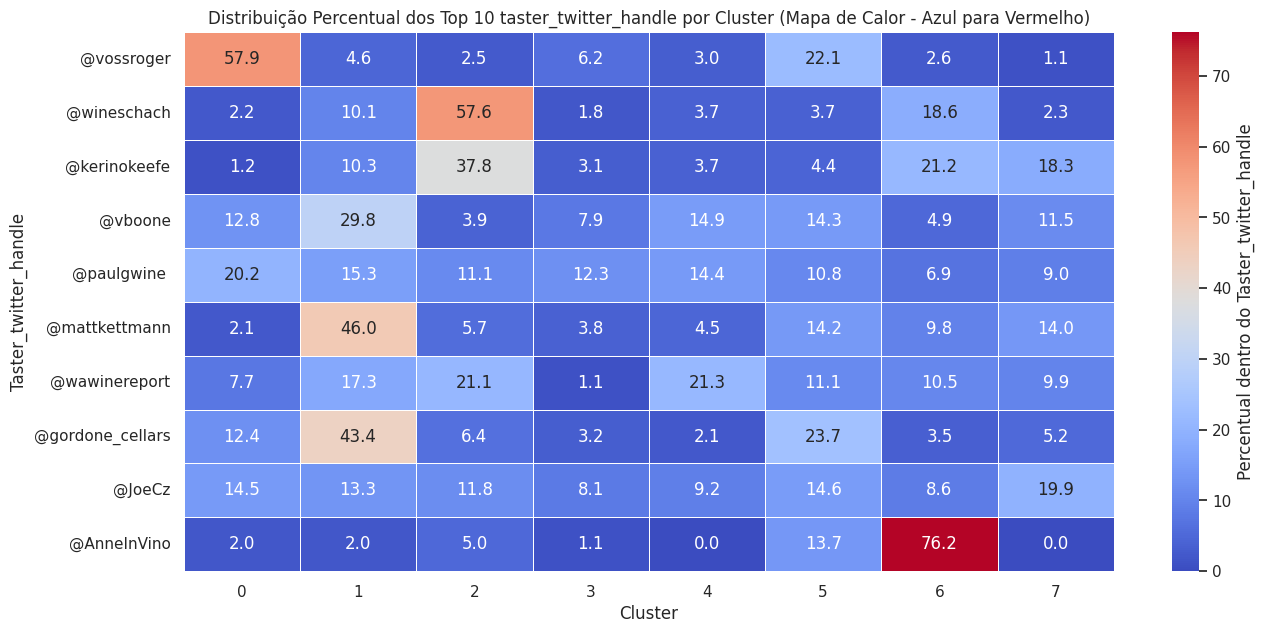

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np # Importar numpy para normalização

def plot_top_n_heatmap_per_cluster_normalized_by_row(col: str, n: int = 10):
    """
    Gera um mapa de calor mostrando a distribuição percentual das top N entradas
    de uma coluna categórica através dos clusters, normalizado por linha.

    Args:
        col (str): O nome da coluna no DataFrame para analisar (ex: 'designation', 'variety').
        n (int): O número de top entradas a serem incluídas no heatmap.
    """
    # Seleciona as N entradas mais populares da coluna
    # Se n for None, seleciona todas as entradas únicas
    if n is not None:
        top_entries = df[col].value_counts().nlargest(n).index
        title_prefix = f'Top {n} {col.capitalize()}'
        figsize_height = n * 0.5 + 2
        df_top = df[df[col].isin(top_entries)]
    else:
        top_entries = df[col].unique()
        title_prefix = f'Todos os {col.capitalize()}es'
        figsize_height = len(top_entries) * 0.5 + 2
        df_top = df.copy() # Usa o DataFrame completo

    # Cria a tabela de contagem cruzada: linhas = top_entries, colunas = cluster, valores = contagem
    pivot_table = pd.crosstab(df_top[col], df_top['cluster'])

    # Garante que a ordem das linhas no heatmap corresponda à popularidade (se n não for None)
    if n is not None:
         pivot_table = pivot_table.loc[top_entries]

    # --- Normaliza a tabela por linha ---
    # Divide cada valor na linha pela soma dos valores na linha
    pivot_table_normalized = pivot_table.divide(pivot_table.sum(axis=1), axis=0) * 100 # Multiplica por 100 para ter percentual
    # Substitui NaN por 0 em caso de linhas com soma zero (embora improvável com contagens)
    pivot_table_normalized = pivot_table_normalized.fillna(0)
    # --- Fim da normalização ---

    # Cria o mapa de calor a partir dos dados normalizados
    plt.figure(figsize=(15, figsize_height)) # Ajusta o tamanho da figura dinamicamente
    sns.heatmap(
        pivot_table_normalized, # Usa a tabela normalizada
        annot=True,  # Mostrar os números no heatmap (agora percentuais)
        fmt='.1f',   # Formatar os números como floats com 1 casa decimal
        cmap='coolwarm', # Altera a paleta de cores para Azul para Vermelho
        linewidths=.5, # Adiciona linhas entre as células para melhor visualização
        cbar_kws={'label': f'Percentual dentro do {col.capitalize()}'} # Rótulo da barra de cores
    )
    plt.title(f'Distribuição Percentual dos Top {n} {col} por Cluster (Mapa de Calor - Azul para Vermelho)')
    plt.xlabel('Cluster')
    plt.ylabel(col.capitalize())
    plt.show()

# Gerar o mapa de calor normalizado por linha para os top 10 taster_twitter_handle
plot_top_n_heatmap_per_cluster_normalized_by_row(col='taster_twitter_handle', n=10)

In [24]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_taster_cluster_association(df, n_top_tasters: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'taster_twitter_handle' (focando nos top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'taster_twitter_handle' e 'cluster'.
        n_top_tasters (int): O número de top identificadores de provadores a serem incluídos no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona os N identificadores de provadores mais populares
    top_tasters = df['taster_twitter_handle'].value_counts().nlargest(n_top_tasters).index

    # Filtra o DataFrame para incluir apenas as linhas com esses top provadores
    df_filtered = df[df['taster_twitter_handle'].isin(top_tasters)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['taster_twitter_handle'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_tasters} Taster Twitter Handles e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre taster_twitter_handle (top N) e cluster.")
        print("Isso sugere que a distribuição dos taster_twitter_handle é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição dos taster_twitter_handle (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com os top 10 taster_twitter_handle
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_taster_cluster_association(df, n_top_tasters=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Taster Twitter Handles):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Taster Twitter Handles):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Taster Twitter Handles e Clusters:
Estatística Qui-Quadrado: 41886.2489
Valor p: 0.0000
Graus de Liberdade: 63

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre taster_twitter_handle (top N) e cluster.
Isso sugere que a distribuição dos taster_twitter_handle é significativamente diferente entre os clusters.


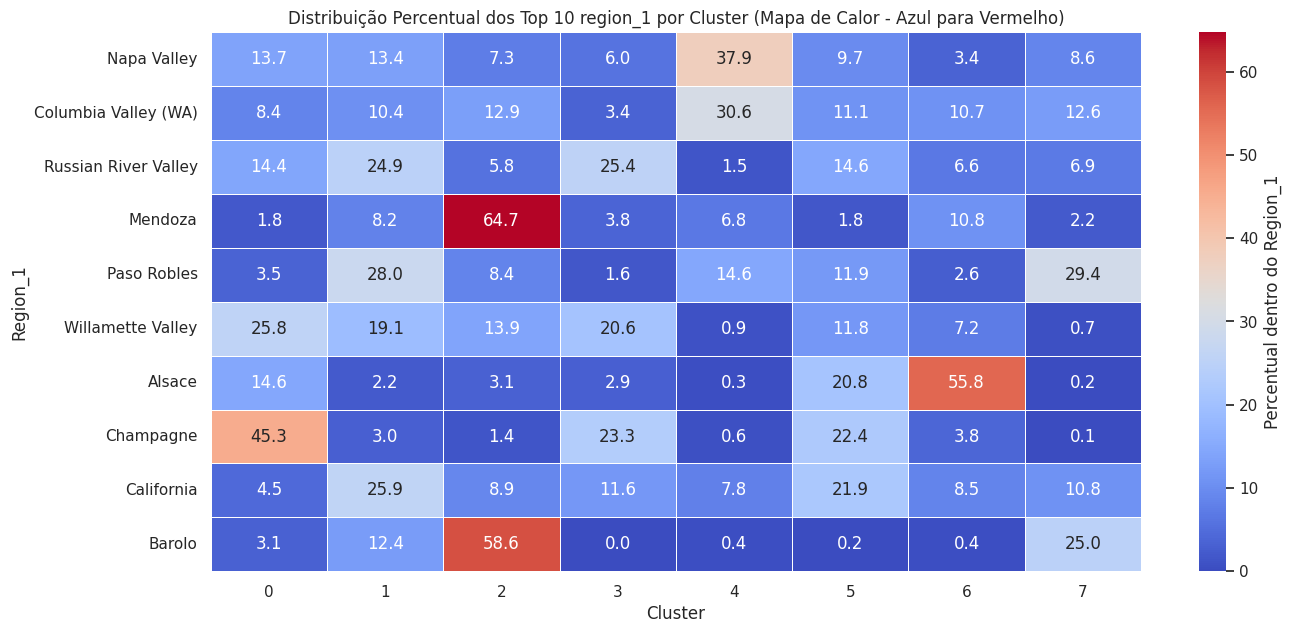

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np # Importar numpy para normalização

def plot_top_n_heatmap_per_cluster_normalized_by_row(col: str, n: int = 10):
    """
    Gera um mapa de calor mostrando a distribuição percentual das top N entradas
    de uma coluna categórica através dos clusters, normalizado por linha.

    Args:
        col (str): O nome da coluna no DataFrame para analisar (ex: 'designation', 'variety').
        n (int): O número de top entradas a serem incluídas no heatmap.
    """
    # Seleciona as N entradas mais populares da coluna
    # Se n for None, seleciona todas as entradas únicas
    if n is not None:
        top_entries = df[col].value_counts().nlargest(n).index
        title_prefix = f'Top {n} {col.capitalize()}'
        figsize_height = n * 0.5 + 2
        df_top = df[df[col].isin(top_entries)]
    else:
        top_entries = df[col].unique()
        title_prefix = f'Todos os {col.capitalize()}es'
        figsize_height = len(top_entries) * 0.5 + 2
        df_top = df.copy() # Usa o DataFrame completo

    # Cria a tabela de contagem cruzada: linhas = top_entries, colunas = cluster, valores = contagem
    pivot_table = pd.crosstab(df_top[col], df_top['cluster'])

    # Garante que a ordem das linhas no heatmap corresponda à popularidade (se n não for None)
    if n is not None:
         pivot_table = pivot_table.loc[top_entries]

    # --- Normaliza a tabela por linha ---
    # Divide cada valor na linha pela soma dos valores na linha
    pivot_table_normalized = pivot_table.divide(pivot_table.sum(axis=1), axis=0) * 100 # Multiplica por 100 para ter percentual
    # Substitui NaN por 0 em caso de linhas com soma zero (embora improvável com contagens)
    pivot_table_normalized = pivot_table_normalized.fillna(0)
    # --- Fim da normalização ---

    # Cria o mapa de calor a partir dos dados normalizados
    plt.figure(figsize=(15, figsize_height)) # Ajusta o tamanho da figura dinamicamente
    sns.heatmap(
        pivot_table_normalized, # Usa a tabela normalizada
        annot=True,  # Mostrar os números no heatmap (agora percentuais)
        fmt='.1f',   # Formatar os números como floats com 1 casa decimal
        cmap='coolwarm', # Altera a paleta de cores para Azul para Vermelho
        linewidths=.5, # Adiciona linhas entre as células para melhor visualização
        cbar_kws={'label': f'Percentual dentro do {col.capitalize()}'} # Rótulo da barra de cores
    )
    plt.title(f'Distribuição Percentual dos Top {n} {col} por Cluster (Mapa de Calor - Azul para Vermelho)')
    plt.xlabel('Cluster')
    plt.ylabel(col.capitalize())
    plt.show()

# Gerar o mapa de calor normalizado por linha para as top 10 regiões
plot_top_n_heatmap_per_cluster_normalized_by_row(col='region_1', n=10)

# Opcional: Gerar o mapa de calor para mais regiões, por exemplo, top 20
# plot_top_n_heatmap_per_cluster_normalized_by_row(col='region_1', n=20)

# Opcional: Gerar o mapa de calor para todas as regiões (pode ficar muito grande)
# plot_top_n_heatmap_per_cluster_normalized_by_row(col='region_1', n=None)

In [26]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_region_cluster_association(df, n_top_regions: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'region_1' (focando nas top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'region_1' e 'cluster'.
        n_top_regions (int): O número de top regiões a serem incluídas no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona as N regiões mais populares
    top_regions = df['region_1'].value_counts().nlargest(n_top_regions).index

    # Filtra o DataFrame para incluir apenas as linhas com essas top regiões
    df_filtered = df[df['region_1'].isin(top_regions)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['region_1'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_regions} Regiões e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre região (top N) e cluster.")
        print("Isso sugere que a distribuição das regiões é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição das regiões (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com as top 10 regiões
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_region_cluster_association(df, n_top_regions=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Regiões):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Regiões):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Regiões e Clusters:
Estatística Qui-Quadrado: 16960.0846
Valor p: 0.0000
Graus de Liberdade: 63

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre região (top N) e cluster.
Isso sugere que a distribuição das regiões é significativamente diferente entre os clusters.


V de Cramer para 'country': 0.2821
V de Cramer para 'designation' (Top 10): 0.3126
V de Cramer para 'variety' (Top 10): 0.4428
V de Cramer para 'taster_twitter_handle' (Top 10): 0.3419


/tmp/ipython-input-27-2056181608.py:81: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




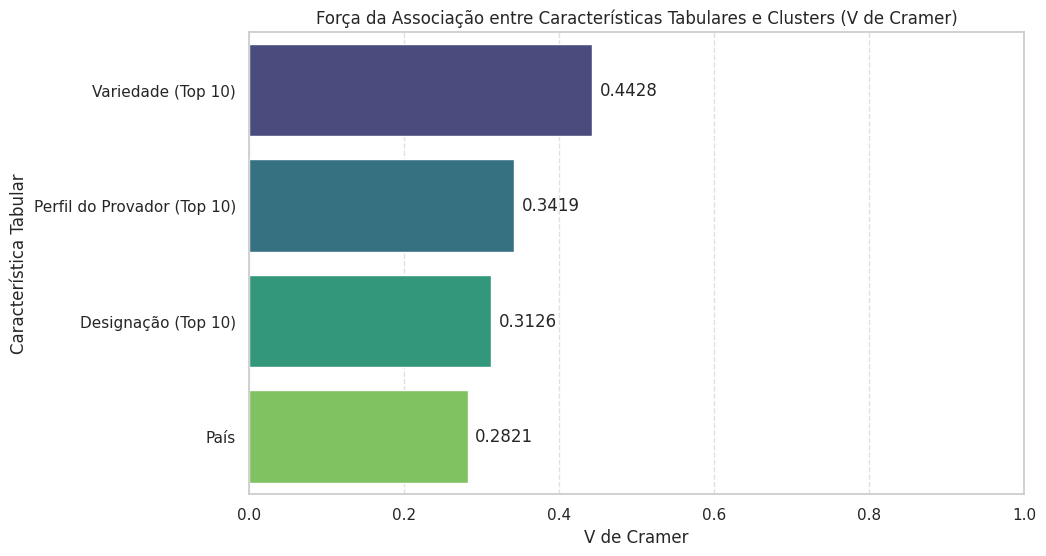

In [27]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def cramers_v(contingency_table):
    """
    Calcula o V de Cramer, uma medida de associação para tabelas de contingência.
    (A função permanece a mesma)

    Args:
        contingency_table (pd.DataFrame): A tabela de contingência (pd.crosstab).

    Returns:
        float: O valor do V de Cramer.
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    # Prevenir divisão por zero se n ou min_dim for zero
    if n == 0 or min_dim == 0:
        return 0.0
    v = np.sqrt(chi2 / (n * min_dim))
    return v

# Assumindo que 'df' é o seu DataFrame já limpo e com a coluna 'cluster'

# --- Calcular V de Cramer para cada característica ---

# V de Cramer para Country (usando todos os países ou top N se preferir consistência com o teste anterior)
# Usaremos todos os países para ter uma visão mais completa, a menos que a memória seja um problema
# top_n_country = 10 # Defina para usar top N
# if top_n_country is not None:
#     top_countries = df['country'].value_counts().nlargest(top_n_country).index
#     df_country = df[df['country'].isin(top_countries)]
# else:
df_country = df.copy()
contingency_country = pd.crosstab(df_country['country'], df_country['cluster'])
v_country = cramers_v(contingency_country)
print(f"V de Cramer para 'country': {v_country:.4f}")

# V de Cramer para Designation (usando top 10 conforme seu teste)
top_n_designation = 10
top_designations = df['designation'].value_counts().nlargest(top_n_designation).index
df_designation = df[df['designation'].isin(top_designations)]
contingency_designation = pd.crosstab(df_designation['designation'], df_designation['cluster'])
v_designation = cramers_v(contingency_designation)
print(f"V de Cramer para 'designation' (Top {top_n_designation}): {v_designation:.4f}")

# V de Cramer para Variety (usando top 10 conforme seu teste)
top_n_variety = 10
top_varieties = df['variety'].value_counts().nlargest(top_n_variety).index
df_variety = df[df['variety'].isin(top_varieties)]
contingency_variety = pd.crosstab(df_variety['variety'], df_variety['cluster'])
v_variety = cramers_v(contingency_variety)
print(f"V de Cramer para 'variety' (Top {top_n_variety}): {v_variety:.4f}")

# V de Cramer para Taster Twitter Handle (usando top 10 conforme seu teste)
top_n_taster = 10
top_tasters = df['taster_twitter_handle'].value_counts().nlargest(top_n_taster).index
df_taster = df[df['taster_twitter_handle'].isin(top_tasters)]
contingency_taster = pd.crosstab(df_taster['taster_twitter_handle'], df_taster['cluster'])
v_taster = cramers_v(contingency_taster)
print(f"V de Cramer para 'taster_twitter_handle' (Top {top_n_taster}): {v_taster:.4f}")

# --- Visualizar os valores de V de Cramer ---

v_scores_data = {
    'Characteristic': ['País', f'Designação (Top {top_n_designation})', f'Variedade (Top {top_n_variety})', f'Perfil do Provador (Top {top_n_taster})'],
    'Cramers_V': [v_country, v_designation, v_variety, v_taster]
}

df_v_scores = pd.DataFrame(v_scores_data)

# Ordena para melhor visualização (do maior para o menor V de Cramer)
df_v_scores = df_v_scores.sort_values('Cramers_V', ascending=False)

plt.figure(figsize=(10, 6))
# Cria o gráfico de barras usando os scores de V de Cramer
ax = sns.barplot(x='Cramers_V', y='Characteristic', data=df_v_scores, palette='viridis')
plt.xlabel("V de Cramer") # Rótulo do eixo X
plt.ylabel("Característica Tabular") # Rótulo do eixo Y
plt.title("Força da Associação entre Características Tabulares e Clusters (V de Cramer)") # Título do gráfico
plt.xlim(0, 1) # Define o limite do eixo X de 0 a 1 (intervalo de V de Cramer)
plt.grid(axis='x', linestyle='--', alpha=0.6) # Adiciona linhas de grade no eixo X

# Adiciona os valores exatos de V de Cramer nas barras
# Iteramos sobre os patches (barras) para obter as posições Y
for p in ax.patches:
    # p.get_width() retorna a largura da barra (o valor de Cramers_V)
    # p.get_y() + p.get_height() / 2 retorna a posição Y central da barra
    ax.text(p.get_width() + 0.01, # Posiciona o texto ligeiramente à direita da barra
            p.get_y() + p.get_height() / 2, # Centraliza o texto verticalmente na barra
            f"{p.get_width():.4f}", # Formata o texto com o valor de Cramers_V
            va='center') # Alinha verticalmente o texto ao centro

plt.show() # Exibe o gráfico

In [28]:
from collections import Counter

def get_top_n_words(corpus, n=None):
    words = [word for sentence in corpus for word in sentence.split()]
    word_counts = Counter(words)
    return word_counts.most_common(n)

# Exemplo: Top 20 palavras para cada cluster
for cluster_id in sorted(df['cluster'].unique()):
    print(f"\nTop palavras para o Cluster {cluster_id}:")
    cluster_descriptions = df[df['cluster'] == cluster_id]['description']
    top_words = get_top_n_words(cluster_descriptions, n=20)
    print(top_words)


Top palavras para o Cluster 0:
[('wine', 12434), ('drink', 4401), ('fruit', 4327), ('flavors', 3933), ('acidity', 3653), ('tannins', 3066), ('ripe', 3059), ('fruits', 2444), ('rich', 2263), ('oak', 2065), ('red', 1665), ('black', 1643), ('age', 1633), ('texture', 1580), ('years', 1545), ('cherry', 1523), ('well', 1510), ('aging', 1314), ('crisp', 1290), ('character', 1283)]

Top palavras para o Cluster 1:
[('wine', 9279), ('flavors', 5472), ('fruit', 4128), ('black', 3899), ('cherry', 3883), ('palate', 3833), ('aromas', 3785), ('tannins', 2825), ('finish', 2820), ('nose', 2456), ('acidity', 2107), ('red', 1992), ('spice', 1834), ('ripe', 1827), ('blackberry', 1675), ('notes', 1609), ('plum', 1609), ('dark', 1584), ('pepper', 1493), ('drink', 1373)]

Top palavras para o Cluster 2:
[('aromas', 7297), ('flavors', 6965), ('palate', 5946), ('finish', 5276), ('tannins', 4590), ('cherry', 4446), ('berry', 4000), ('fruit', 3465), ('black', 3394), ('plum', 3277), ('drink', 3165), ('spice', 271

In [ ]:
print(len(embeddings))

NameError: name 'embeddings' is not defined

In [29]:
# prompt: printar todas as colunas do dataframe

print(df.columns.tolist())


['Unnamed: 0', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery', 'cluster']
